<a href="https://colab.research.google.com/github/microsoft/FLAML/blob/main/notebook/autogen_agent_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive LLM Agent with Auto Feedback from Code Execution

FLAML offers an experimental feature of interactive LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or uses auto-feedback based on the result of code execution. For example, when `human_input_mode` is set to "ALWAYS", the `UserProxyAgent` will always prompt the user for feedback. When user feedback is provided, the `UserProxyAgent` will directly pass the feedback to `AssistantAgent` without doing any additional steps. When no user feedback is provided, the `UserProxyAgent` will execute the code written by `AssistantAgent` directly and return the execution results (success or failure and corresponding outputs) to `AssistantAgent`.

## Requirements

FLAML requires `Python>=3.8`. To run this notebook example, please install flaml with the [autogen] option:
```bash
pip install flaml[autogen]
```

In [1]:
# %pip install flaml[autogen]==2.0.0rc3

## Set your API Endpoint

The [`config_list_from_models`](https://microsoft.github.io/FLAML/docs/reference/autogen/oai/openai_utils#config_list_from_models) function tries to create a list of configurations using Azure OpenAI endpoints and OpenAI endpoints for the provided list of models. It assumes the api keys and api bases are stored in the corresponding environment variables or local txt files:

- OpenAI API key: os.environ["OPENAI_API_KEY"] or `openai_api_key_file="key_openai.txt"`.
- Azure OpenAI API key: os.environ["AZURE_OPENAI_API_KEY"] or `aoai_api_key_file="key_aoai.txt"`. Multiple keys can be stored, one per line.
- Azure OpenAI API base: os.environ["AZURE_OPENAI_API_BASE"] or `aoai_api_base_file="base_aoai.txt"`. Multiple bases can be stored, one per line.

It's OK to have only the OpenAI API key, or only the Azure OpenAI API key + base.


In [2]:
from flaml import oai

config_list = oai.config_list_from_models(model_list=["gpt-4"])

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },  # only if OpenAI API key is found
    {
        'model': 'gpt-4',
        'api_key': '<your first Azure OpenAI API key here>',
        'api_base': '<your first Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-03-15-preview',
    },  # only if the at least one Azure OpenAI API key is found
    {
        'model': 'gpt-4',
        'api_key': '<your second Azure OpenAI API key here>',
        'api_base': '<your second Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-03-15-preview',
    },  # only if the second Azure OpenAI API key is found
]
```

You can directly override it if the above function returns an empty list, i.e., it doesn't find the keys in the specified locations.

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in FLAML to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [3]:
from flaml.autogen.agent import AssistantAgent, UserProxyAgent

# create an AssistantAgent named "assistant"
assistant = AssistantAgent(
    "assistant",
    seed=42,
    config_list=config_list,
    temperature=0,
)
# create a UserProxyAgent instance named "user"
user = UserProxyAgent(
    "user",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE") or x.get("content", "").rstrip().endswith('"TERMINATE".'),
    work_dir="coding",
    use_docker=False,  # set to True if you are using docker
)
# the assistant receives a message from the user, which contains the task description
assistant.receive(
    """What date is today? Compare the year-to-date gain for META and TESLA.""",
    user,
)

user (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user):

To get the current date and compare the year-to-date gain for META and TESLA, we can use the `datetime` and `yfinance` libraries in Python. The `yfinance` library allows us to download stock market data from Yahoo Finance.

Here is the Python code to do this:

```python
# filename: stock_comparison.py

import datetime
import yfinance as yf

# Get today's date
today = datetime.date.today()
print("Today's date:", today)

# Get the data for the stock META and TESLA
meta = yf.Ticker("META")
tesla = yf.Ticker("TSLA")

# Get the historical data for this year
meta_data = meta.history(start=f'{today.year}-01-01', end=str(today))
tesla_data = tesla.history(start=f'{today.year}-01-01', end=str(today))

# Calculate the year-to-date gain for each stock
meta_gain = (meta_data['Close'][-1] - meta_data['Clos

The example above involves code execution. In FLAML, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, FLAML defaults to the `flaml/autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.


All the feedback is auto generated.

## Example Task: Plot Chart

In [4]:
# followup of the previous question
assistant.receive(
    """Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
    user
)

user (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user):

To plot a chart of the stock price change year-to-date (YTD) for META and TESLA and save it to a file, we can use the `matplotlib` library in Python. Here is the Python code to do this:

```python
# filename: stock_price_plot.py

import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# Get today's date
today = datetime.date.today()

# Get the data for the stock META and TESLA
meta = yf.Ticker("META")
tesla = yf.Ticker("TSLA")

# Get the historical data for this year
meta_data = meta.history(start=f'{today.year}-01-01', end=str(today))
tesla_data = tesla.history(start=f'{today.year}-01-01', end=str(today))

# Plot the closing price of META and TESLA
plt.figure(figsize=(14, 7))
plt.plot(meta_data['Close'], label='META')
plt.plot(tesla_data['Close'], label='TESLA')
plt.tit

Let's display the generated figure.

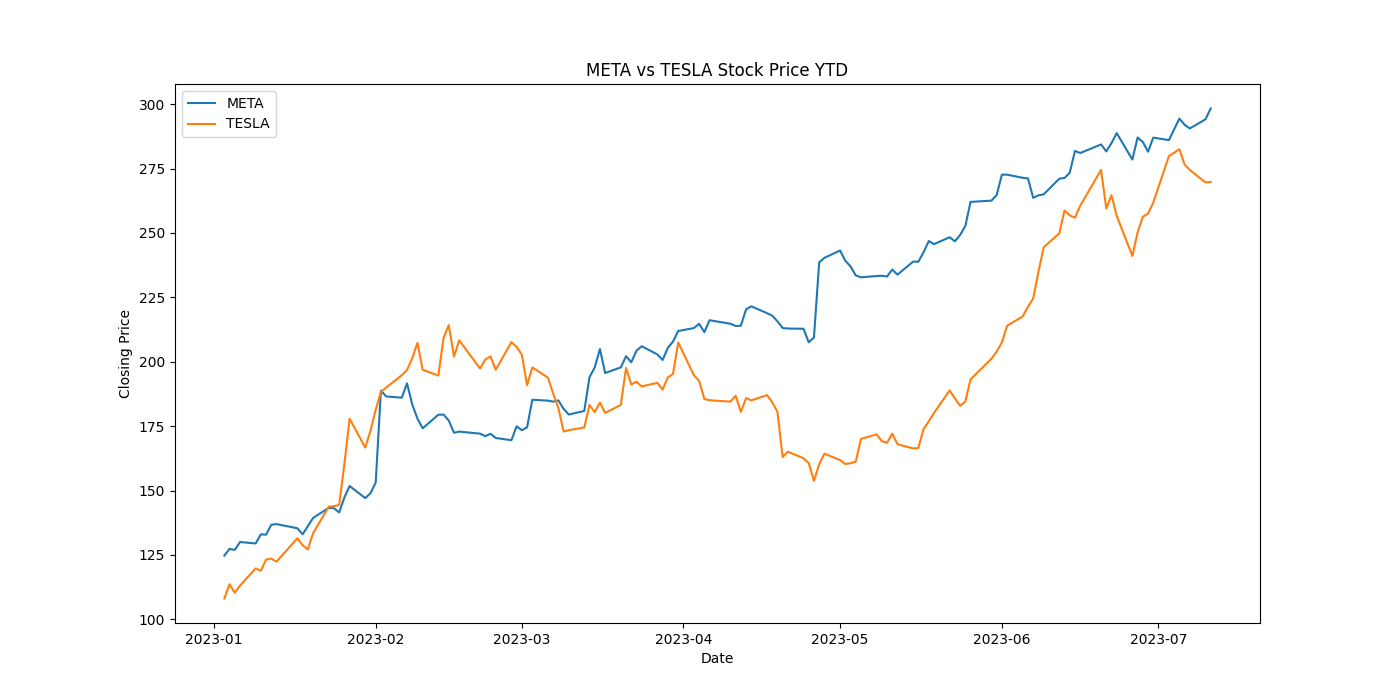

In [5]:
from IPython.display import Image

Image(filename='coding/stock_price_ytd.png')